## Dataset
Máme k dispozici soubor dat z reálné teplárny umístěné ve středně velkém městě v Evropě. Teplárna ohřívá vodu a distribuuje teplo po celém městě. Naším cílem je předpovědět teplotu vratné vody na základě aktuálních a historických nastavení výkonu teplárny, výstupní teploty vody a venkovních teplot naměřených na různých místech ve městě.

In [1]:
# constants
ORIGINAL_DATA_FILE = '.\\data\\data_original.csv'
DATA_FILE = '.\\data\\data.csv'
LOG_DIR = '.\\RESULTS'

EPOCHS = 100

### Sloučení dat ze souborů do jednoho data frame a případné konverze sloupců

In [2]:
# data file
import pandas as pd
import os

def prepare_orig_data_file(file_path, rw=False):
    if os.path.exists(file_path):
        return

    # vykon ohrevu v sektoru 1 and 2 [MW]
    power12 = pd.read_csv("power12.csv", sep=",")
    # vykon ohrevu v sektoru 3 [MW]
    power3 = pd.read_csv("power3.csv",sep=",")
    # vykon ohrevu v sektoru 4 [MW]
    power4 = pd.read_csv("power4.csv",sep=",")
    # teplota v lokaci #1
    temp1 = pd.read_csv("temp1.csv",sep=",")
    # teplota v lokaci #2
    temp2 = pd.read_csv("temp2.csv",sep=",")
    # teplota v lokaci #3
    temp3 = pd.read_csv("temp3.csv",sep=",")
    # teplota v lokaci #4
    temp4 = pd.read_csv("temp4.csv",sep=",")
    # teplota v lokaci #5
    temp5 = pd.read_csv("temp5.csv",sep=",")
    # teplota vody na vstupu
    temp_in = pd.read_csv("temp_in.csv", sep=",")
    # teplota vody na vystupu
    temp_out = pd.read_csv("temp_out.csv",sep=",")

    # celkovy vykon ohrevu
    data = (
        power12[["ts", "power12"]]
        .merge(power3[["ts", "power3"]], on="ts")
        .merge(power4[["ts", "power4"]], on="ts")
    )

    # teploty ze vsech lokaci
    data = data.merge(temp1[["ts", "temp1"]], on="ts")
    data = data.merge(temp2[["ts", "temp2"]], on="ts")
    data = data.merge(temp3[["ts", "temp3"]], on="ts")
    data = data.merge(temp4[["ts", "temp4"]], on="ts")
    data = data.merge(temp5[["ts", "temp5"]], on="ts")

    # vstupni a vystupni teploty
    data = data.merge(temp_in[["ts", "temp_in"]], on="ts")
    data = data.merge(temp_out[["ts", "temp_out"]], on="ts")

    # konverze casu
    data["ts"] = pd.to_datetime(data["ts"])

    data.to_csv(file_path, index=False)

prepare_orig_data_file(ORIGINAL_DATA_FILE)

### Čištění dat

In [3]:
# Nacteni dat
data = pd.read_csv(ORIGINAL_DATA_FILE)
# konverze casu
data["ts"] = pd.to_datetime(data["ts"])

print(f"Velikost datasetu: {len(data)}")
data.head()

Velikost datasetu: 13829


,ts,power12,power3,power4,temp1,temp2,temp3,temp4,temp5,temp_in,temp_out
0,2018-12-31 20:00:00+00:00,53.461340,87.796477,105.498682,3.011382,4.319544,3.913138,4.772481,3.598558,45.346010,79.611295
1,2018-12-31 21:00:00+00:00,54.464130,74.151459,105.017897,3.439440,4.909789,4.428925,5.561646,4.411865,45.350819,80.416664
2,2018-12-31 22:00:00+00:00,54.191047,70.918662,105.600836,3.637795,5.066491,4.603145,5.854397,4.684823,45.396163,80.992841
3,2018-12-31 23:00:00+00:00,54.243952,69.949829,106.664194,3.694362,5.293024,4.542157,5.981506,4.747482,45.402380,81.630635
4,2019-01-01 00:00:00+00:00,53.277664,68.645953,106.001002,3.739370,5.414588,4.739108,6.081391,4.883813,45.440688,81.685051


In [4]:
# Nevalidni teplota na vstupu
data = data[data["temp_in"] != 0.0]
print(f"Velikost datasetu: {len(data)}")

Velikost datasetu: 13104


In [5]:
# Nevalidni teplota na vystupu
data = data[data["temp_out"] != 0.0]
print(f"Velikost datasetu: {len(data)}")

Velikost datasetu: 13104


**Identifikace mezer v řadě**

Provedeno porovnáním časových razítek údajů, kdy je kontrolováno, zda rozdíl mezi po sobě jdoucími odpovídá frekvenci 1 hodina.

Místa, kde je porušená následnost, jsou označena a budou následně sloužit k rozdělení řady na dílčí.

In [6]:
# Identifikace mezer v case
from datetime import timedelta

data['gap'] = (data['ts'] - data['ts'].shift(1)) != timedelta(hours=1)
print(f"Velikost datasetu: {len(data)}")
data.head()

Velikost datasetu: 13104


,ts,power12,power3,power4,temp1,temp2,temp3,temp4,temp5,temp_in,temp_out,gap
0,2018-12-31 20:00:00+00:00,53.461340,87.796477,105.498682,3.011382,4.319544,3.913138,4.772481,3.598558,45.346010,79.611295,True
1,2018-12-31 21:00:00+00:00,54.464130,74.151459,105.017897,3.439440,4.909789,4.428925,5.561646,4.411865,45.350819,80.416664,False
2,2018-12-31 22:00:00+00:00,54.191047,70.918662,105.600836,3.637795,5.066491,4.603145,5.854397,4.684823,45.396163,80.992841,False
3,2018-12-31 23:00:00+00:00,54.243952,69.949829,106.664194,3.694362,5.293024,4.542157,5.981506,4.747482,45.402380,81.630635,False
4,2019-01-01 00:00:00+00:00,53.277664,68.645953,106.001002,3.739370,5.414588,4.739108,6.081391,4.883813,45.440688,81.685051,False


### Vytvoření sekvencí z časové řady
Protože je časová řada nesouvislá, musí být rozdělena na dílčí souvislé sekvence, na kterých bude probíhat učení.

V každé sekvenci je zachováno pořadí, ale musí být odstraněno časové razítko jako index.

Teplotní údaje jsou převedeny ze °C na °F a následně normalizovány. Normalizace je provedena i na údajích o výkonu.

Následně jsou sekvence rozděleny na trénovací a validační část v poměru 80:20.

In [7]:
# Vyreseni nesouvislosti casove rady

attributes_pred = [
    "power12",
    "power3",
    "power4"
]

temperatures = [
        "temp1",
        "temp2",
        "temp3",
        "temp4",
        "temp5",
        "temp_in",
        "temp_out"
]

attributes = data.columns[data.columns != "gap"]

sequences = []

data[temperatures] = data[temperatures] + 273.15
max = data[attributes[1:]].max()
data[attributes[1:]] = data[attributes[1:]] / max

start = 0
for stop in range(1, len(data)):
    if data.iloc[stop]["gap"]:
        sequences.append(data[start:stop][attributes])
        start = stop

train_dataset_list = []
valid_dataset_list = []

for sequence in sequences:
    split_idx = int(0.8 * len(sequence))
    if split_idx > 0:
        train_dataset_list.append(sequence.iloc[:split_idx].copy())
    if split_idx < len(sequence):
        valid_dataset_list.append(sequence.iloc[:split_idx].copy())

### Problém s velikostí sekvencí
Některé sekvence jsou příliš krátké a mohly by negativně ovlivnit výsledek, navíc by způsobovaly problémy s výpočtem některých metrik. Z toho důvodu jsou v průběhu kontrolovány na délku a krátké jsou vyřazeny.

## Učení
Pro trénování jsem připravil celkem 4 modely:
- MyGRU = vlastní GRU
- GRU
- LSTM
- Transformer

Všechny modely trénovány stejnou trénovací smyčkou s vyhodnocením stejných metrik.

In [8]:
# MyGRU
from GRU import MyGRUModel, MyGRUTraining

model_mygru = MyGRUModel(
    input_size=len(attributes) - 1,
    hidden_size=64,
    output_size=len(attributes_pred),
)

training_mygru = MyGRUTraining(
    model=model_mygru,
    log_path=f"{LOG_DIR}\\MYGRU\\LOG",
    model_path=".\\MYGRU\\",
    training_dataset_list=train_dataset_list,
    validation_dataset_list=valid_dataset_list,
    target_cols=attributes_pred,
)
training_mygru.run(EPOCHS)

Training started at 2025-08-24T18:47:51.876669
	Epoch   0	Training: loss: 0.0382	MSE: 0.0382	MAE: 0.1127	R2: -0.1229	Validation: loss: 0.0362	MSE: 0.0362	MAE: 0.1162	R2: 0.1120
	Epoch   1	Training: loss: 0.0123	MSE: 0.0123	MAE: 0.0682	R2: 0.6166	Validation: loss: 0.0162	MSE: 0.0162	MAE: 0.0797	R2: 0.5357
	Epoch   2	Training: loss: 0.0046	MSE: 0.0046	MAE: 0.0400	R2: 0.8175	Validation: loss: 0.0051	MSE: 0.0051	MAE: 0.0440	R2: 0.8042
	Epoch   3	Training: loss: 0.0020	MSE: 0.0020	MAE: 0.0240	R2: 0.9183	Validation: loss: 0.0018	MSE: 0.0018	MAE: 0.0242	R2: 0.9301
	Epoch   4	Training: loss: 0.0012	MSE: 0.0012	MAE: 0.0174	R2: 0.9644	Validation: loss: 0.0011	MSE: 0.0011	MAE: 0.0186	R2: 0.9681
	Epoch   5	Training: loss: 0.0010	MSE: 0.0010	MAE: 0.0157	R2: 0.9749	Validation: loss: 0.0010	MSE: 0.0010	MAE: 0.0172	R2: 0.9721
	Epoch   6	Training: loss: 0.0009	MSE: 0.0009	MAE: 0.0151	R2: 0.9767	Validation: loss: 0.0010	MSE: 0.0010	MAE: 0.0167	R2: 0.9733
	Epoch   7	Training: loss: 0.0009	MSE: 0.0009	MAE

In [9]:
# GRU
from GRU import GRUModel, GRUTraining

model_gru = GRUModel(
    input_size=len(attributes) - 1,
    hidden_size=64,
    output_size=len(attributes_pred),
)

training_gru = GRUTraining(
    model=model_gru,
    log_path="{LOG_DIR}\\GRU\\LOG",
    model_path=".\\GRU\\",
    training_dataset_list=train_dataset_list,
    validation_dataset_list=valid_dataset_list,
    target_cols=attributes_pred,
)
training_gru.run(EPOCHS)

Training started at 2025-08-24T19:16:06.005699
	Epoch   0	Training: loss: 0.0342	MSE: 0.0342	MAE: 0.1200	R2: 0.1474	Validation: loss: 0.0430	MSE: 0.0430	MAE: 0.1244	R2: 0.0358
	Epoch   1	Training: loss: 0.0163	MSE: 0.0163	MAE: 0.0806	R2: 0.5404	Validation: loss: 0.0250	MSE: 0.0250	MAE: 0.0987	R2: 0.3753
	Epoch   2	Training: loss: 0.0073	MSE: 0.0073	MAE: 0.0529	R2: 0.7276	Validation: loss: 0.0098	MSE: 0.0098	MAE: 0.0627	R2: 0.6730
	Epoch   3	Training: loss: 0.0038	MSE: 0.0038	MAE: 0.0358	R2: 0.8271	Validation: loss: 0.0039	MSE: 0.0039	MAE: 0.0338	R2: 0.8172
	Epoch   4	Training: loss: 0.0029	MSE: 0.0029	MAE: 0.0287	R2: 0.8666	Validation: loss: 0.0029	MSE: 0.0029	MAE: 0.0270	R2: 0.8629
	Epoch   5	Training: loss: 0.0022	MSE: 0.0022	MAE: 0.0245	R2: 0.9040	Validation: loss: 0.0021	MSE: 0.0021	MAE: 0.0220	R2: 0.9111
	Epoch   6	Training: loss: 0.0016	MSE: 0.0016	MAE: 0.0200	R2: 0.9442	Validation: loss: 0.0013	MSE: 0.0013	MAE: 0.0182	R2: 0.9597
	Epoch   7	Training: loss: 0.0011	MSE: 0.0011	MAE:

In [10]:
# Transformer
from Transformer import TransformerTraining, TransformerModel

model_transformer = TransformerModel(
    input_size=len(attributes) - 1,
    output_size=len(attributes_pred)
)

training_transformer = TransformerTraining(
    model=model_transformer,
    log_path="{LOG_DIR}\\TRANS\\LOG",
    model_path=".\\TRANS\\",
    training_dataset_list=train_dataset_list,
    validation_dataset_list=valid_dataset_list,
    target_cols=attributes_pred,
)

training_transformer.run(EPOCHS)

Training started at 2025-08-24T19:18:44.630808
	Epoch   0	Training: loss: 0.0176	MSE: 0.0176	MAE: 0.0884	R2: 0.2955	Validation: loss: 0.0100	MSE: 0.0100	MAE: 0.0585	R2: 0.6792
	Epoch   1	Training: loss: 0.0052	MSE: 0.0052	MAE: 0.0539	R2: 0.8132	Validation: loss: 0.0061	MSE: 0.0061	MAE: 0.0440	R2: 0.8268
	Epoch   2	Training: loss: 0.0035	MSE: 0.0035	MAE: 0.0440	R2: 0.8819	Validation: loss: 0.0035	MSE: 0.0035	MAE: 0.0337	R2: 0.9210
	Epoch   3	Training: loss: 0.0026	MSE: 0.0026	MAE: 0.0377	R2: 0.9188	Validation: loss: 0.0032	MSE: 0.0032	MAE: 0.0332	R2: 0.9280
	Epoch   4	Training: loss: 0.0022	MSE: 0.0022	MAE: 0.0342	R2: 0.9354	Validation: loss: 0.0029	MSE: 0.0029	MAE: 0.0315	R2: 0.9398
	Epoch   5	Training: loss: 0.0018	MSE: 0.0018	MAE: 0.0310	R2: 0.9451	Validation: loss: 0.0022	MSE: 0.0022	MAE: 0.0288	R2: 0.9544
	Epoch   6	Training: loss: 0.0017	MSE: 0.0017	MAE: 0.0294	R2: 0.9512	Validation: loss: 0.0033	MSE: 0.0033	MAE: 0.0315	R2: 0.9371
	Epoch   7	Training: loss: 0.0015	MSE: 0.0015	MAE:

In [11]:
# LSTM
from LSTM import LSTMModel, LSTMTraining

model_lstm = LSTMModel(
    input_size=len(attributes) - 1,
    hidden_size=64,
    output_size=len(attributes_pred)
)

trainingLSTM = LSTMTraining(
    model=model_lstm,
    log_path="{LOG_DIR}\\LSTM\\LOG",
    model_path=".\\LSTM\\",
    training_dataset_list=train_dataset_list,
    validation_dataset_list=valid_dataset_list,
    target_cols=attributes_pred,
)


trainingLSTM.run(EPOCHS)

Training started at 2025-08-24T19:24:07.742739
	Epoch   0	Training: loss: 0.0589	MSE: 0.0589	MAE: 0.1510	R2: -0.4211	Validation: loss: 0.0515	MSE: 0.0515	MAE: 0.1360	R2: -0.1799
	Epoch   1	Training: loss: 0.0204	MSE: 0.0204	MAE: 0.0895	R2: 0.4333	Validation: loss: 0.0349	MSE: 0.0349	MAE: 0.1141	R2: 0.1092
	Epoch   2	Training: loss: 0.0097	MSE: 0.0097	MAE: 0.0582	R2: 0.6452	Validation: loss: 0.0097	MSE: 0.0097	MAE: 0.0576	R2: 0.5634
	Epoch   3	Training: loss: 0.0052	MSE: 0.0052	MAE: 0.0396	R2: 0.7625	Validation: loss: 0.0068	MSE: 0.0068	MAE: 0.0441	R2: 0.7052
	Epoch   4	Training: loss: 0.0042	MSE: 0.0042	MAE: 0.0350	R2: 0.8181	Validation: loss: 0.0051	MSE: 0.0051	MAE: 0.0382	R2: 0.7871
	Epoch   5	Training: loss: 0.0034	MSE: 0.0034	MAE: 0.0307	R2: 0.8718	Validation: loss: 0.0035	MSE: 0.0035	MAE: 0.0332	R2: 0.8833
	Epoch   6	Training: loss: 0.0024	MSE: 0.0024	MAE: 0.0253	R2: 0.9329	Validation: loss: 0.0038	MSE: 0.0038	MAE: 0.0359	R2: 0.9102
	Epoch   7	Training: loss: 0.0020	MSE: 0.0020	MA

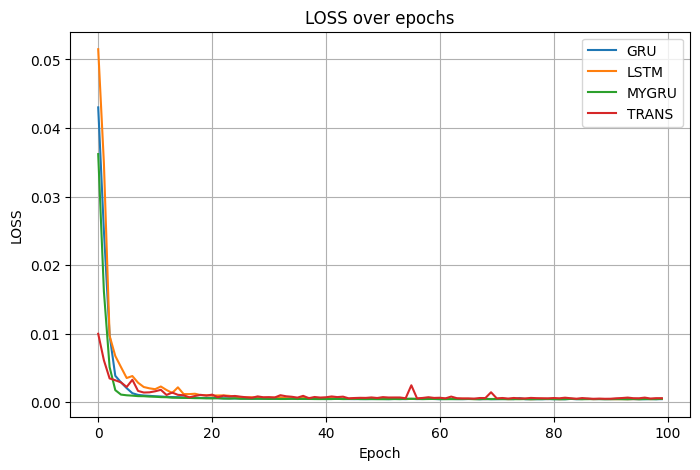

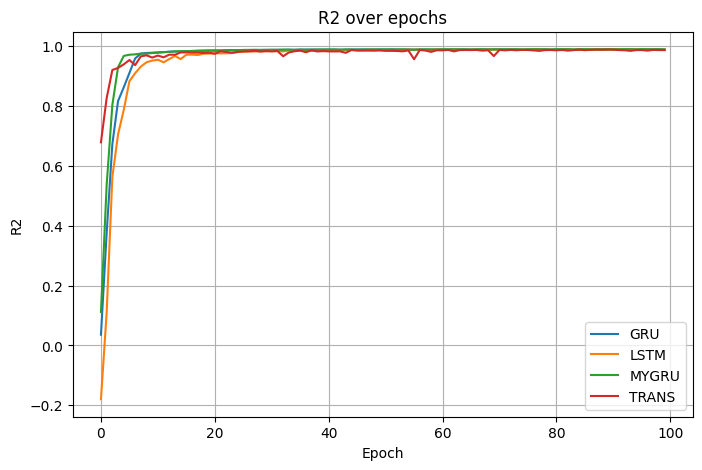

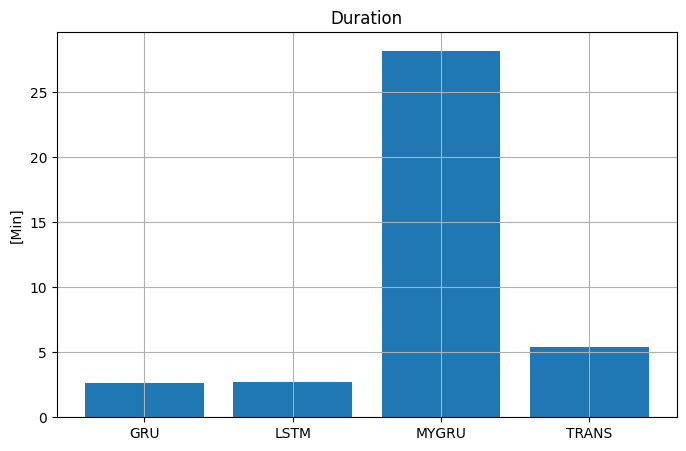

In [2]:
from result import Result
res = Result(base_dir=LOG_DIR)
res.show_metrics()

In [ ]:
from GRU import MyGRUModel, MyGRUTraining
import torch

model_mygru = MyGRUModel(
    input_size=len(attributes) - 1,
    hidden_size=64,
    output_size=len(attributes_pred),
)
model_mygru.load_state_dict(
    torch.load(".\\test\\MYGRU\\2025-08-24-11-18-59Z.pth", weights_only=True)
)
model_mygru.eval()


